# Import

In [1]:
import os, sys

import pandas as pd
import polars as pl

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import scipy

import sklearn
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import dproc, sgml, sgnn, sgpp, sgutil

print(sys.version)
for i in [pd, pl, mpl, sns, np, scipy, sklearn, lgb, xgb, cb]:
    try:
        print(i.__name__, i.__version__)
    except:
        pass

2025-02-02 23:29:55.269843: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-02 23:29:55.546203: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-02 23:29:56.433939: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


3.12.3 (main, May  1 2024, 17:33:23) [GCC 11.4.0]
pandas 2.2.2
polars 1.12.0
matplotlib 3.8.4
seaborn 0.13.2
numpy 1.26.4
scipy 1.13.0
sklearn 1.4.2
lightgbm 4.3.0
xgboost 2.1.2
catboost 1.2.5


In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit

from scipy.stats import spearmanr, kruskal, chi2_contingency
from scipy.spatial.distance import cdist, pdist, squareform

# Download

In [3]:
for i in ['data', 'model', 'img', 'result']:
    if not os.path.exists(i):
        os.mkdir(i)

if not os.path.exists(os.path.join('data', 'train.csv')):
    !kaggle competitions download -c playground-series-s5e2
    !kaggle datasets download souradippal/student-bag-price-prediction-dataset
    !unzip student-bag-price-prediction-dataset.zip -d data
    !unzip playground-series-s5e2.zip -d data
    !rm playground-series-s5e2.zip
    !rm student-bag-price-prediction-dataset.zip

# Preparation

In [4]:
sc = sgutil.SGCache('img', 'result')

In [5]:
files = {
    'train': os.path.join('data', 'train.csv'),
    'test': os.path.join('data', 'test.csv'),
    'org': os.path.join('data', 'Noisy_Student_Bag_Price_Prediction_Dataset.csv')
}

In [6]:
t = sc.cache_result(
    'pipeline_1',
    lambda : make_pipeline(
        sgpp.PolarsProcessor(), 
        sgpp.PandasCoverter(index_col = 'id'),
    ).fit(files['train']),
    rerun = 1
)
df_train = t.transform(files['train'])
df_test = t.transform(files['test'])
df_org = t.transform(files['org'])
df_org.set_index(-(df_org.index.rename('id') + 1), inplace=True)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 0 to 299999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Brand                 290295 non-null  category
 1   Material              291653 non-null  category
 2   Size                  293405 non-null  category
 3   Compartments          300000 non-null  float32 
 4   Laptop Compartment    292556 non-null  category
 5   Waterproof            292950 non-null  category
 6   Style                 292030 non-null  category
 7   Color                 290050 non-null  category
 8   Weight Capacity (kg)  299862 non-null  float32 
 9   Price                 300000 non-null  float32 
dtypes: category(7), float32(3)
memory usage: 6.6 MB


In [8]:
target = 'Price'
X_cat = df_train.dtypes.pipe(
    lambda x: x.loc[x == 'category'].index.tolist()
)
X_num = df_train.dtypes.pipe(
    lambda x: x.loc[(x != 'category') & (x.index != target)].index.tolist()
)
X_all = X_cat + X_num
target, X_cat, X_num

('Price',
 ['Brand',
  'Material',
  'Size',
  'Laptop Compartment',
  'Waterproof',
  'Style',
  'Color'],
 ['Compartments', 'Weight Capacity (kg)'])

# EDA

## Train / Test / Org Diff

In [9]:
ss = ShuffleSplit(n_splits = 1, random_state = 123)

X_cat_diff = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
X_num_diff = ['Compartments', 'Weight Capacity (kg)']
X_all_diff = X_cat_diff + X_num_diff

sc.cache_result(
    'train_test_diff',
    lambda : pd.concat([df_train[X_all_diff].assign(is_train = True), df_test[X_all_diff].assign(is_train = False)], axis = 0).dropna().pipe(
        lambda x: cross_val_score(lgb.LGBMClassifier(verbose = 0), x[X_all_diff], x['is_train'], cv = ss, scoring = 'roc_auc')
    )
)

array([0.50166391])

In [10]:
X_cat_diff = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
X_num_diff = ['Compartments', 'Weight Capacity (kg)', target]
X_all_diff = X_cat_diff + X_num_diff

sc.cache_result(
    'train_org_diff',
    lambda : pd.concat([df_train[X_all_diff].assign(is_train = True), df_org[X_all_diff].assign(is_train = False)], axis = 0).dropna().pipe(
        lambda x: cross_val_score(lgb.LGBMClassifier(verbose = 0), x[X_all_diff], x['is_train'], cv = ss, scoring = 'roc_auc')
    )
)

array([0.61373943])

## Missing Values

In [11]:
df_train[X_all].isna().mean().pipe(
    lambda x: x.loc[x > 0].rename('na_ratio').to_frame().T
)

,Brand,Material,Size,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
na_ratio,0.03235,0.027823,0.021983,0.024813,0.0235,0.026567,0.033167,0.00046


## Target

In [12]:
df_train[target].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
Price,300000.0,81.41111,39.039341,15.0,47.384621,80.956123,115.018158,150.0


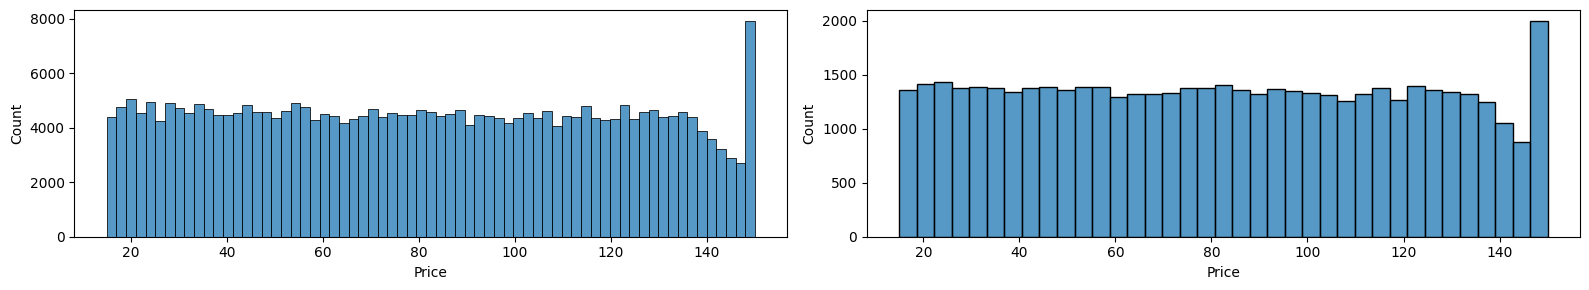

In [13]:
_, axes = plt.subplots(1, 2, figsize = (16, 3))
sns.histplot(df_train[target], ax = axes[0])
sns.histplot(df_org[target], ax = axes[1])
plt.tight_layout()
plt.show()

## Categorical Variables

In [32]:
sc.cache_result(
    'kruskal_target',
    lambda : pd.concat([
        pd.Series(
            kruskal(*df_train.groupby(i, observed=True)[target].agg(list)), index=['stat', 'pvalue'], name=i
        ) for i in X_cat
    ], axis=1), rerun = 0
).T.join(df_train[X_cat].nunique().rename('nunique')).sort_values('pvalue', ascending = True)

,stat,pvalue,nunique
Material,94.397776,2.487334e-20,4
Color,81.778818,3.560963e-16,6
Brand,42.562866,1.275070e-08,5
Waterproof,1.589209,2.074391e-01,2
Size,2.902191,2.343134e-01,3
Laptop Compartment,0.009281,9.232525e-01,2
Style,0.068897,9.661381e-01,3


In [30]:
pd.DataFrame(
    squareform(
        sc.cache_result(
            'chi2_variables',
            lambda : pdist(df_train[X_cat].T, lambda u, v: chi2_contingency(pd.crosstab(u, v)).pvalue)
        )
    ), index = X_cat, columns = X_cat
)

,Brand,Material,Size,Laptop Compartment,Waterproof,Style,Color
Brand,0.000000e+00,1.326258e-07,0.093020,1.240839e-01,1.814956e-01,0.029342,0.479126
Material,1.326258e-07,0.000000e+00,0.000014,8.355747e-02,9.095699e-01,0.140027,0.038341
Size,9.302043e-02,1.374196e-05,0.000000,7.578808e-01,9.230872e-01,0.032041,0.012190
Laptop Compartment,1.240839e-01,8.355747e-02,0.757881,0.000000e+00,3.246753e-56,0.004470,0.007520
Waterproof,1.814956e-01,9.095699e-01,0.923087,3.246753e-56,0.000000e+00,0.789501,0.483258
Style,2.934222e-02,1.400270e-01,0.032041,4.469708e-03,7.895010e-01,0.000000,0.147923
Color,4.791256e-01,3.834111e-02,0.012190,7.520067e-03,4.832583e-01,0.147923,0.000000


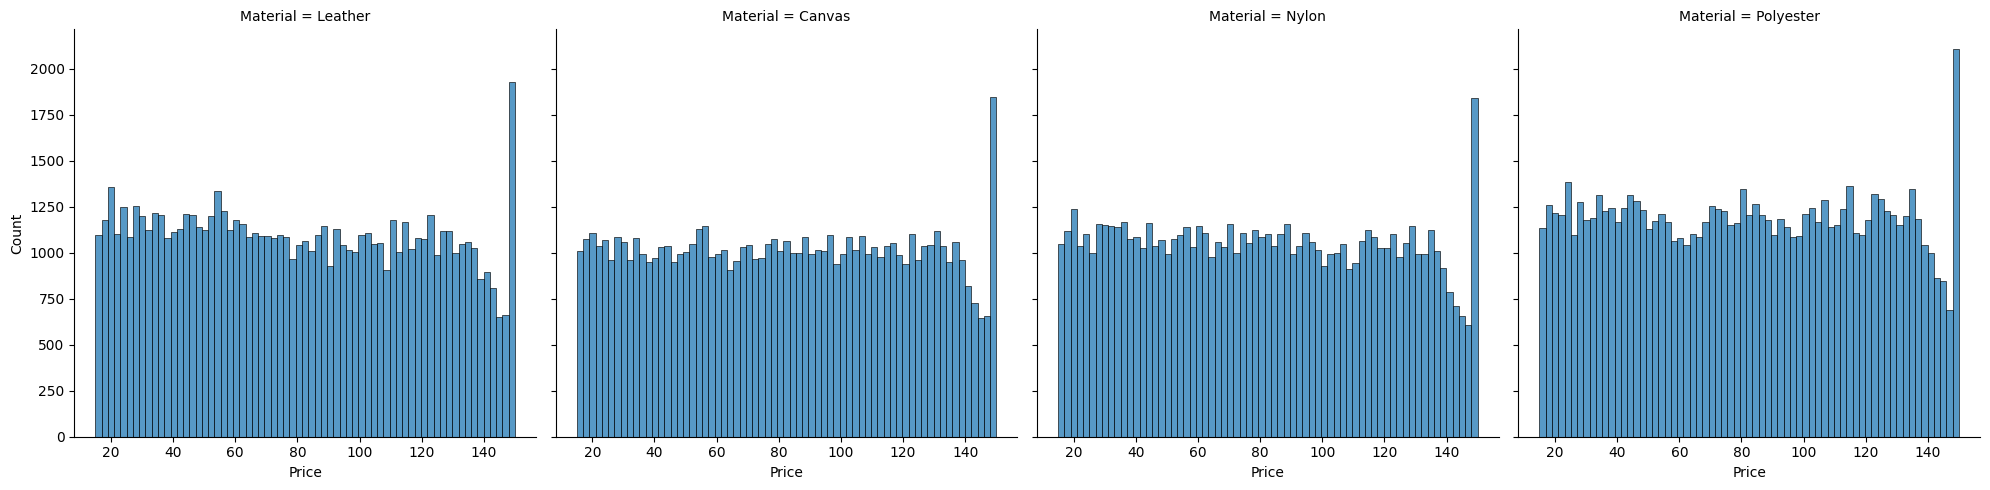

In [35]:
sns.displot(df_train, x = target , col = 'Material')
plt.show()